# Canada Emissions Breakdown
In this notebook we will explore a territorial breakdown of Canadian emissions into provinces using data submitted to UNFCCC.

In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

In [2]:
from openclimate import Client
client = Client()
client.jupyter

Let's display all of dataset's available for Canada

In [200]:
client.emissions_datasets('CA')

,actor_id,datasource_id,name,publisher,published,URL
0,CA,BP:statistical_review_june2022,"Statistical Review of World Energy all data, 1...",BP,2022-06-01T00:00:00.000Z,https://www.bp.com/en/global/corporate/energy-...
1,CA,EDGARv7.0:ghg,Emissions Database for Global Atmospheric Rese...,JRC,2022-01-01T00:00:00.000Z,https://edgar.jrc.ec.europa.eu/dataset_ghg70
2,CA,GCB2022:national_fossil_emissions:v1.0,Data supplement to the Global Carbon Budget 20...,GCP,2022-11-04T00:00:00.000Z,https://www.icos-cp.eu/science-and-impact/glob...
3,CA,PRIMAP:10.5281/zenodo.7179775:v2.4,PRIMAP-hist_v2.4_no_extrap (scenario=HISTCR),PRIMAP,2022-10-17T00:00:00.000Z,https://zenodo.org/record/7179775
4,CA,UNFCCC:GHG_ANNEX1:2019-11-08,"UNFCCC GHG total without LULUCF, ANNEX I count...",UNFCCC,2019-11-08T00:00:00.000Z,https://di.unfccc.int/time_series
5,CA,climateTRACE:country_inventory,climate TRACE: country inventory,climate TRACE,2022-12-02T00:00:00.000Z,https://climatetrace.org/inventory
6,CA,WRI:climate_watch_historical_ghg:2022,Climate Watch Historical GHG Emissions,WRI,2022-01-01T00:00:00.000Z,https://www.climatewatchdata.org/ghg-emissions


Now let's gather emissions data for Canada from UNFCCC as well as emissions for each province from ECCC. Finally, let's gather population data for Canada and its provinces from 2017 (this is the most recent year we have emissions for all provinces).

In [6]:
# canadian emissions
df_ca = client.emissions('CA', 'UNFCCC:GHG_ANNEX1:2019-11-08')

# canadian province names
df_parts = client.parts('CA', part_type='adm1')[['actor_id', 'name']]

# province emissions
df_prov = client.emissions(df_parts.actor_id, 'ECCC:GHG_inventory:2022-04-13')

# candian population in 2017
df_ca_pop = (
    client.population('CA')
    .loc[lambda x: x['year'] == 2017, ['actor_id', 'year', 'population']]
)

# province population in 2017
df_prov_pop = (
    client.population(df_parts.actor_id)
    .loc[lambda x: x['year'] == 2017, ['actor_id', 'year', 'population']]
)

Now let's select Canadian emissions and provincial emissions for 2020. I know it's not the same year as population, but let's assum popluation hasn't changed signifcantly in three years. We are also going to convert to megatonnes of CO2 equivalents by dividing by dividing the emissions by a million. 

In [ ]:
# national emissions in MTCO2e
national = df_ca.loc[df_ca['year'] == 2020, 'total_emissions'].values / 10**6

# province emissions and cumulative emissions in MTCO2e
df_out = (
    df_prov
    .loc[df_prov['year'] == 2020, ['total_emissions', 'actor_id']]
    .assign(total_emissions= lambda x: x['total_emissions'].div(10**6), inplace=True)
    .assign(percent_of_national = lambda x: (x['total_emissions'] / national) * 100)
    .sort_values(by='percent_of_national', ascending=False)
    .assign(cumulative = lambda x: x['percent_of_national'].cumsum())
    .merge(df_parts, on='actor_id')
    .merge(df_prov_pop, on='actor_id')
    .assign(percent_of_population = lambda x: (x['population'] / x['population'].sum()) * 100)
    .rename(columns={'total_emissions': 'total_emissions_[MTCO2e]'})
    .loc[:, ['actor_id', 'name', 'total_emissions_[MTCO2e]', 'percent_of_national',  'cumulative', 'population', 'percent_of_population']]
)

Now let's display a table showing the province, emissions breakdown, and population. 

In [199]:
df_out

,actor_id,name,total_emissions_[MTCO2e],percent_of_national,cumulative,population,percent_of_population
0,CA-AB,Alberta,256.459542,38.143528,38.143528,4306039,11.674212
1,CA-ON,Ontario,149.584918,22.247940,60.391467,14279196,38.712694
2,CA-QC,Quebec,76.241175,11.339439,71.730907,8425996,22.843933
3,CA-SK,Saskatchewan,65.894159,9.800515,81.531422,1168057,3.166749
4,CA-BC,British Columbia,61.746788,9.183672,90.715094,4841078,13.124770
5,CA-MB,Manitoba,21.674064,3.223609,93.938703,1343371,3.642047
6,CA-NS,Nova Scotia,14.596446,2.170946,96.109649,957600,2.596174
7,CA-NB,New Brunswick,12.440907,1.850351,97.960000,760868,2.062809
8,CA-NL,Newfoundland and Labrador,9.500844,1.413072,99.373072,528430,1.432640
9,CA-PE,Prince Edward Island,1.609972,0.239453,99.612525,152784,0.414217


This shows that 5 provines (Albera, Ontario, Quebec, Saskatchewan, and British Columbia) make up over 90% of Canada's overall emissions in 2020. Alberta, while only accounting for about 12% of Canada's population contributes to 38% of the nation's emissions. This is largely driven by [oil/gas and agriculture sectors](https://businesscouncilab.com/work/albertas-emissions-profile-is-unique-this-is-why-it-matters/#:~:text=The%20reason%20Alberta%20is%20an,and%20electricity%20and%20agriculture%20sectors).

Finally, let's make a first attempt at visulaizating this breakdow. This bar graph is clunky and could be improved.

Text(0, 0.5, '% of national emissions')

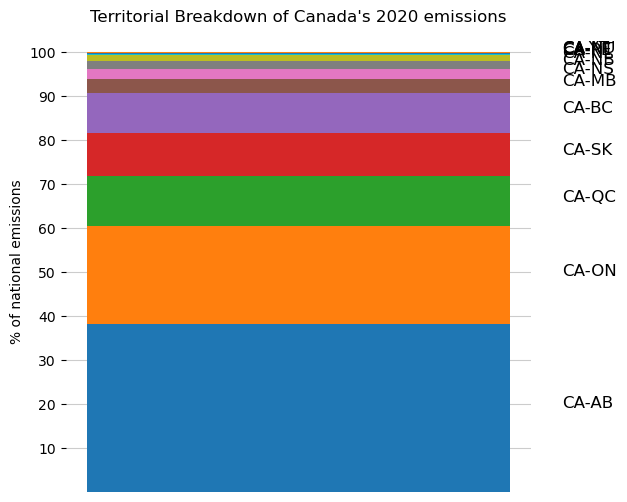

In [268]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

previous = 0
for iterator, row in df_out.iterrows():
    emissions = row['percent_of_national']
    cumulative = row['cumulative']
    actor_id = row['actor_id']
    ax.bar(1, emissions, bottom=previous, label=actor_id)
    previous = cumulative
    ax.text(1.5, previous - (emissions/2), 
          actor_id, 
          fontsize=12, 
          color='k')
    
# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# grid and tick marks
ax.set_yticks(np.arange(10, 110, 10))
ax.grid(axis='y',
        which='major',
        color=[0.8, 0.8, 0.8], linestyle='-')

ax.set_axisbelow(True)
ax.set_xticks([])
ax.set_title("Territorial Breakdown of Canada's 2020 emissions")
ax.set_ylabel("% of national emissions")